In [ ]:
import pandas as pd
import numpy as np
import re
import networkx
from networkx.algorithms.components.connected import connected_components
from collections import defaultdict
import random
import glob
import os
from Bio import SeqIO
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import jaccard_score
import time
start = time.time()

# Loading MIBiG dataframes and creating dictionaries

In [ ]:
bioactivity_df = pd.read_csv("./bioactivity_df-220203.csv",sep='\t',index_col=0)

bioactivity_dict = dict(zip(bioactivity_df['metabolite'],bioactivity_df['activity']))

bioactivity_dict

In [ ]:
np.unique(list(bioactivity_dict.values()))

In [ ]:
mibig_df = pd.read_csv("./All_MIBiG_compounds_with_CF_NPC_classes.txt",sep='\t')

mibig_df

In [ ]:
mibig_activity_dict = {}
missing_mets_list = []

for i,r in mibig_df.iterrows():
    met_name = r['compound_name'].split('_')[1].replace(' ','_').lower().split('_')[0]
    for key in bioactivity_dict.keys():
        if type(key) != float:
            if met_name in key:
                print(r['compound_name'].split('_')[0],met_name,key,bioactivity_dict[key])
                if type(bioactivity_dict[key]) == float:
                    mibig_activity_dict[r['compound_name'].split('_')[0]] = 'unknown'
                else:
                    mibig_activity_dict[r['compound_name'].split('_')[0]] = bioactivity_dict[key]
            else:
                missing_mets_list.append(met_name)

In [ ]:
len(mibig_activity_dict)

In [ ]:
mibig_activity_dict

In [ ]:
mibig_bio_3_df = pd.read_csv('./mibig_3_bioactivity.csv',sep='\t',names=['MIBIG_ID','Activity'])

mibig_bio_3_dict = dict(zip(mibig_bio_3_df['MIBIG_ID'],mibig_bio_3_df['Activity']))

mibig_bio_3_dict

In [ ]:
for key in mibig_activity_dict:
    if mibig_activity_dict[key] == 'unknown':
        if key in mibig_bio_3_dict.keys():
            mibig_activity_dict[key] = mibig_bio_3_dict[key].lower()

for key in mibig_bio_3_dict:
    if key not in mibig_activity_dict:
        mibig_activity_dict[key] = mibig_bio_3_dict[key].lower()

In [ ]:
bgc_subtype_df = pd.read_csv("./bgc_subtype_df.csv",'\t',names=['BGC','subtype'])

bgc_subtype_df

In [ ]:
subtype_type_dict = {}
with open("./subtype_type_df.csv") as f:
    for line in f:
        (key, val) = line.split(',')
        subtype_type_dict[key] = val.strip('\n')
        
subtype_type_dict

In [ ]:
type_col = []

for i,r in bgc_subtype_df.iterrows():
    type_col.append(subtype_type_dict[r['subtype']])
    
bgc_subtype_df['type'] = type_col

bgc_subtype_df

In [ ]:
bgc_type_dict = dict(zip(bgc_subtype_df.BGC,bgc_subtype_df.type))

bgc_type_dict

# Creating class dataframe

In [14]:
combined_list,all_classes,type_list = [],[],[]

for key in bgc_type_dict:
    if 'tRNA' in bgc_type_dict[key]:
        type_list = ['tRNA_derived']
    else:
        type_list = bgc_type_dict[key].split('-')
    for item in type_list:
        if item not in all_classes:
            all_classes.append(item)
    combined_list.append(type_list)
    
combined_list

[['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['Other'],
 ['Alkaloid', 'PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['Oligosaccharide'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['Oligosaccharide', 'PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['Oligosaccharide', 'PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['Oligosaccharide', 'PKS'],
 ['PKS'],
 ['PKS'

In [15]:
class_df = pd.DataFrame(columns=(all_classes))

bgc_list = list(bgc_type_dict.keys())

for i,combined_classes in enumerate(combined_list):
    row_extension = []
    for final_class in all_classes:
        if final_class in combined_classes:
            row_extension.append(1)
        else:
            row_extension.append(0)
    class_df.loc[bgc_list[i]] = row_extension
    
class_df = class_df.sort_index(axis=0)
    
class_df

,PKS,Other,Alkaloid,Oligosaccharide,Terpene,NRPS,Cyclitol,Aminocoumarin,Betalactam,Siderophore,Pyrrolobenzodiazepine,RiPP,Butyrolactone,Nucleoside,Phenazine,Aminoglycoside,tRNA_derived,Phosphonate
BGC0000001,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BGC0000002,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BGC0000003,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BGC0000004,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BGC0000005,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BGC0002045,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BGC0002055,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BGC0002056,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BGC0002057,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Creating similarity dataframe

In [16]:
### obtaining bigscape dataframe and bigscape dictionary

def parse_bigscape_df(input_file,no_orphans):
    bigscape_df = pd.read_csv(input_file,sep='\t')
    bigscape_df.rename(columns=lambda x: re.sub(" ","_",x), inplace=True)
    if no_orphans == 1:
        bigscape_df = bigscape_df[bigscape_df.Clustername_1 != bigscape_df.Clustername_2]
    bigscape_df.reset_index(inplace=True,drop=True)
    return bigscape_df

def get_neighbors(target,dataframe,column1,column2):
    subset1 = dataframe[(dataframe[column1]==target)]
    subcat = subset1.append(dataframe[(dataframe[column2]==target)])
    temp_list = []
    for index,row in subcat.iterrows():
        temp_list.append(subcat[column1][index])
        temp_list.append(subcat[column2][index])
    temp_list = list(np.unique(temp_list))
    return temp_list

def to_edges(l):
    it = iter(l)
    last = next(it)
    for current in it:
        yield last, current
        last = current

def to_graph(l):
    G = networkx.Graph()
    for part in l:
        G.add_nodes_from(part)
        G.add_edges_from(to_edges(part))
    return G

def get_family_dict(components_list,dataframe,dictionary,column1,column2,column3):
    count = 0
    for family in list(components_list):
        count += 1
        for fam_member in family:
            dictionary['GCF%s'%count].append(fam_member)
    return dictionary

def main_get_families(input_file):
    bigscape_df = parse_bigscape_df(input_file,1)
    strain_list = list(np.unique([bigscape_df['Clustername_1']]+[bigscape_df['Clustername_2']]))
    targets_list = np.unique([bigscape_df.Clustername_1,bigscape_df.Clustername_2])
    neighbors_list = []
    for target in targets_list:
        neighbors_list.append(get_neighbors(target,bigscape_df,'Clustername_1','Clustername_2'))
    G = to_graph(neighbors_list)
    C = connected_components(G)
    gcf_dict = defaultdict(list)
    gcf_dict = get_family_dict(C,bigscape_df,gcf_dict,'Clustername_1','Clustername_2','Raw_distance')
    return bigscape_df,gcf_dict,strain_list


bigscape_df,bigscape_dict,strain_list = main_get_families("./bigscape_all_c030.txt")
bigscape_df["Raw_distance"] = 1-bigscape_df["Raw_distance"]

bigscape_dict

defaultdict(list,
            {'GCF1': ['BGC0000006.1.region001',
              'BGC0000009.1.region001',
              'BGC0000007.1.region001',
              'BGC0000008.1.region001',
              'BGC0000004.1.region001'],
             'GCF2': ['BGC0001511.1.region001', 'BGC0000020.1.region001'],
             'GCF3': ['BGC0000029.1.region001',
              'BGC0000097.1.region001',
              'BGC0001349.1.region001'],
             'GCF4': ['BGC0000031.1.region001', 'BGC0001533.1.region001'],
             'GCF5': ['BGC0000061.1.region001', 'BGC0000034.1.region001'],
             'GCF6': ['BGC0001396.1.region001',
              'BGC0000047.1.region001',
              'BGC0000035.1.region001'],
             'GCF7': ['BGC0000039.1.region001', 'BGC0000098.1.region001'],
             'GCF8': ['BGC0001580.1.region001', 'BGC0000051.1.region001'],
             'GCF9': ['BGC0000059.1.region001', 'BGC0002032.1.region001'],
             'GCF10': ['BGC0000062.1.region001', 'BGC0000063.1.re

In [17]:
len(bigscape_dict)

192

In [18]:
bigscape_df2 = parse_bigscape_df("./bigscape_all_c030.txt",0)
all_clusters = list(np.unique([bigscape_df2['Clustername_1']]+[bigscape_df2['Clustername_2']]))

len(all_clusters)

1627

In [19]:
strain_list_renamed = []

for item in strain_list:
    strain_list_renamed.append(item.split('.')[0])
    
strain_list_renamed = list(np.unique(strain_list_renamed))

similarity_df = pd.DataFrame(columns=strain_list_renamed, index=range(0,len(strain_list_renamed)-1))
index_row = 0
row_names = []
for gcf in bigscape_dict:
    for cluster in bigscape_dict[gcf]:
        row_names.append(cluster.split('.')[0])
        temp_dict = {}
        self = cluster.split(".")[0]
        temp_dict[self] = [1]
        temp_df = bigscape_df[bigscape_df.Clustername_1.str.contains(cluster) | 
                              bigscape_df.Clustername_2.str.contains(cluster)]
        for i,r in temp_df.iterrows():
            if temp_df.Clustername_1.loc[i] == cluster:
                target = temp_df.Clustername_2.loc[i]
                target = str(target).split(".")[0]
                if target not in temp_dict:
                    temp_dict[target] = [temp_df.Raw_distance.loc[i]]
                else:
                    temp_dict[target] = temp_dict[target]+[temp_df.Raw_distance.loc[i]]
            else:
                target = temp_df.Clustername_1.loc[i]
                target = str(target).split(".")[0]
                if target not in temp_dict.keys():
                    temp_dict[target] = [temp_df.Raw_distance.loc[i]]
                else:
                    temp_dict[target] = temp_dict[target]+[temp_df.Raw_distance.loc[i]]
        for key in temp_dict:
            if len(temp_dict[key]) > 1:
                new_value = max(temp_dict[key])
                temp_dict[key] = new_value
            else:
                temp_dict[key] = temp_dict[key][0]
        similarity_df.loc[index_row] = pd.Series(temp_dict)
        index_row += 1
similarity_df.fillna(0,inplace=True)
similarity_df.index = row_names
similarity_df = similarity_df[~similarity_df.index.duplicated(keep='first')]
similarity_df = similarity_df.sort_index(axis=0)

len(strain_list_renamed),len(similarity_df)

(520, 520)

In [20]:
similarity_df

,BGC0000004,BGC0000006,BGC0000007,BGC0000008,BGC0000009,BGC0000020,BGC0000029,BGC0000031,BGC0000034,BGC0000035,...,BGC0002012,BGC0002015,BGC0002016,BGC0002022,BGC0002023,BGC0002027,BGC0002029,BGC0002030,BGC0002032,BGC0002033
BGC0000004,1.000000,0.976806,0.953003,0.976330,0.880436,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BGC0000006,0.976806,1.000000,0.972632,0.997759,0.895077,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BGC0000007,0.953003,0.972632,1.000000,0.972158,0.893131,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BGC0000008,0.976330,0.997759,0.972158,1.000000,0.894979,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BGC0000009,0.880436,0.895077,0.893131,0.894979,1.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BGC0002027,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
BGC0002029,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
BGC0002030,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
BGC0002032,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [21]:
cluster_list_renamed = []

for item in all_clusters:
    cluster_list_renamed.append(item.split('.')[0])
    
cluster_list_renamed = list(np.unique(cluster_list_renamed))

In [22]:
# orphan_list = []

# for cluster in cluster_list_renamed:
#     if cluster not in similarity_df.index:
#         orphan_list.append(cluster)
#         new_col = []
#         for index in similarity_df.index:
#             new_col.append(0)
#         similarity_df[cluster] = new_col
        
# similarity_df = similarity_df.sort_index(axis=1)
        
# similarity_df

In [23]:
# for cluster in cluster_list_renamed:
#     if cluster not in similarity_df.index:
#         new_row = []
#         for col in similarity_df.columns:
#             if cluster == col:
#                 new_row.append(1)
#             else:
#                 new_row.append(0)
#         similarity_df.loc[cluster] = new_row
        
# similarity_df

# Filtering and merging dataframes

In [24]:
filt_class_df = class_df.loc[similarity_df.index, :]

filt_class_df

,PKS,Other,Alkaloid,Oligosaccharide,Terpene,NRPS,Cyclitol,Aminocoumarin,Betalactam,Siderophore,Pyrrolobenzodiazepine,RiPP,Butyrolactone,Nucleoside,Phenazine,Aminoglycoside,tRNA_derived,Phosphonate
BGC0000004,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BGC0000006,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BGC0000007,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BGC0000008,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BGC0000009,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BGC0002027,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
BGC0002029,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BGC0002030,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BGC0002032,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [25]:
merged_training_df = filt_class_df.join(similarity_df, how='outer')

merged_training_df

,PKS,Other,Alkaloid,Oligosaccharide,Terpene,NRPS,Cyclitol,Aminocoumarin,Betalactam,Siderophore,...,BGC0002012,BGC0002015,BGC0002016,BGC0002022,BGC0002023,BGC0002027,BGC0002029,BGC0002030,BGC0002032,BGC0002033
BGC0000004,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BGC0000006,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BGC0000007,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BGC0000008,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BGC0000009,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BGC0002027,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
BGC0002029,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
BGC0002030,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
BGC0002032,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [26]:
label_col = []

for i,r in merged_training_df.iterrows():
    if i in mibig_activity_dict:
        label_col.append(mibig_activity_dict[i])
    else:
        label_col.append('unlabeled')
        
label_col

['unlabeled',
 'unlabeled',
 'unlabeled',
 'unlabeled',
 'unlabeled',
 'cytotoxic',
 'antibacterial',
 'antibacterial-cytotoxic',
 'antifungal',
 'antibacterial',
 'unlabeled',
 'antibacterial',
 'antifungal',
 'antifungal',
 'antifungal',
 'unlabeled',
 'unlabeled',
 'unlabeled',
 'antifungal-cytotoxic',
 'antifungal-cytotoxic',
 'cytotoxic',
 'unlabeled',
 'unlabeled',
 'antifungal-cytotoxic',
 'antibacterial-cytotoxic',
 'antibacterial',
 'antibacterial',
 'unlabeled',
 'cytotoxic',
 'antibacterial',
 'antifungal',
 'unlabeled',
 'antibacterial',
 'antifungal',
 'antibacterial',
 'antifungal',
 'unlabeled',
 'antibacterial-antifungal',
 'cytotoxic',
 'antifungal',
 'antibacterial',
 'antibacterial',
 'antibacterial',
 'antibacterial',
 'cytotoxic',
 'antifungal-cytotoxic',
 'antifungal-cytotoxic',
 'antifungal-cytotoxic',
 'antibacterial',
 'antiviral',
 'cytotoxic',
 'cytotoxic',
 'antibacterial',
 'unknown',
 'unlabeled',
 'antibacterial-cytotoxic',
 'antibacterial-cytotoxic',
 'a

In [27]:
merged_training_df['label'] = label_col

labeled_training_df = merged_training_df[merged_training_df['label'] != 'unlabeled']

labeled_training_df

,PKS,Other,Alkaloid,Oligosaccharide,Terpene,NRPS,Cyclitol,Aminocoumarin,Betalactam,Siderophore,...,BGC0002015,BGC0002016,BGC0002022,BGC0002023,BGC0002027,BGC0002029,BGC0002030,BGC0002032,BGC0002033,label
BGC0000020,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,cytotoxic
BGC0000029,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,antibacterial
BGC0000031,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,antibacterial-cytotoxic
BGC0000034,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,antifungal
BGC0000035,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,antibacterial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BGC0002015,0,0,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,antibacterial
BGC0002022,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,antibacterial
BGC0002029,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,antibacterial-antifungal
BGC0002032,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,antifungal


In [28]:
np.unique(labeled_training_df['label'])

array(['antibacterial', 'antibacterial-antifungal',
       'antibacterial-antifungal-cytotoxic', 'antibacterial-cytotoxic',
       'antifungal', 'antifungal-cytotoxic', 'antiviral', 'cytotoxic',
       'cytotoxic-unknown', 'inhibitor', 'other', 'pigment',
       'siderophore', 'unknown'], dtype=object)

In [29]:
list(labeled_training_df.columns)

['PKS',
 'Other',
 'Alkaloid',
 'Oligosaccharide',
 'Terpene',
 'NRPS',
 'Cyclitol',
 'Aminocoumarin',
 'Betalactam',
 'Siderophore',
 'Pyrrolobenzodiazepine',
 'RiPP',
 'Butyrolactone',
 'Nucleoside',
 'Phenazine',
 'Aminoglycoside',
 'tRNA_derived',
 'Phosphonate',
 'BGC0000004',
 'BGC0000006',
 'BGC0000007',
 'BGC0000008',
 'BGC0000009',
 'BGC0000020',
 'BGC0000029',
 'BGC0000031',
 'BGC0000034',
 'BGC0000035',
 'BGC0000039',
 'BGC0000047',
 'BGC0000051',
 'BGC0000059',
 'BGC0000061',
 'BGC0000062',
 'BGC0000063',
 'BGC0000064',
 'BGC0000066',
 'BGC0000067',
 'BGC0000074',
 'BGC0000076',
 'BGC0000077',
 'BGC0000083',
 'BGC0000084',
 'BGC0000086',
 'BGC0000087',
 'BGC0000090',
 'BGC0000091',
 'BGC0000096',
 'BGC0000097',
 'BGC0000098',
 'BGC0000100',
 'BGC0000108',
 'BGC0000113',
 'BGC0000115',
 'BGC0000116',
 'BGC0000118',
 'BGC0000119',
 'BGC0000125',
 'BGC0000130',
 'BGC0000132',
 'BGC0000136',
 'BGC0000137',
 'BGC0000145',
 'BGC0000157',
 'BGC0000158',
 'BGC0000177',
 'BGC0000181

# Running cross-validatin for class and similarity

In [30]:
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

X = labeled_training_df.drop('label',axis=1)
y = labeled_training_df['label']

# Use label_binarize to be multi-label like settings
Y = label_binarize(y, classes=list(np.unique(y)))
# Y = label_binarize(y, classes=['antibacterial','cytotoxic','antifungal','antibacterial-cytotoxic','antibacterial-antifungal','antifungal-cytotoxic'])
n_classes = Y.shape[1]
random_state = np.random.RandomState(0)

# Split into training and test
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=random_state
)

In [31]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

classifier = OneVsRestClassifier(
    make_pipeline(StandardScaler(), LinearSVC(random_state=random_state))
)
classifier.fit(X_train, Y_train)
y_score = classifier.decision_function(X_test)

/Users/tiagoferreiraleao/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tiagoferreiraleao/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tiagoferreiraleao/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tiagoferreiraleao/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tiagoferreiraleao/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: Convergence

In [32]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    Y_test.ravel(), y_score.ravel()
)
average_precision["micro"] = average_precision_score(Y_test, y_score, average="micro")

/Users/tiagoferreiraleao/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:681: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


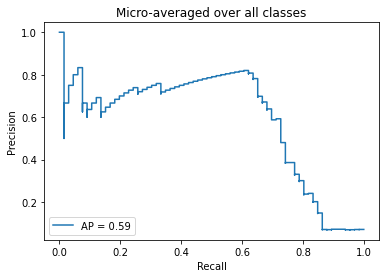

In [33]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot()
_ = display.ax_.set_title("Micro-averaged over all classes")

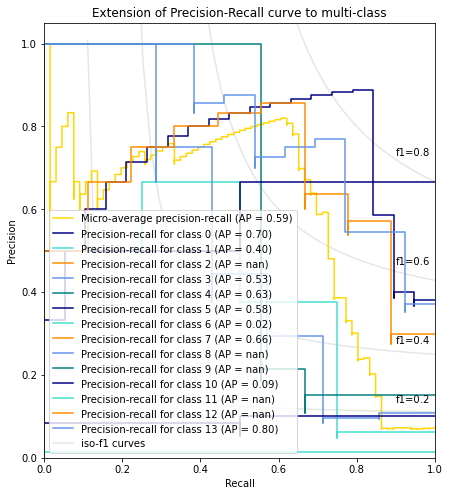

In [34]:
import matplotlib.pyplot as plt
from itertools import cycle

# setup plot details
colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

_, ax = plt.subplots(figsize=(7, 8))

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

for i, color in zip(range(n_classes), colors):
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        average_precision=average_precision[i],
    )
    display.plot(ax=ax, name=f"Precision-recall for class {i}", color=color)

# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])
# set the legend and the axes
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.legend(handles=handles, labels=labels, loc="best")
ax.set_title("Extension of Precision-Recall curve to multi-class")

plt.show()

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

# Import some data to play with
# iris = datasets.load_iris()
# X = iris.data
# y = iris.target
X = labeled_training_df.drop('label',axis=1)
y = labeled_training_df['label']

# Binarize the output
Y = label_binarize(y, classes=list(np.unique(y)))
n_classes = len(np.unique(y))

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(
    svm.SVC(kernel="linear", probability=True, random_state=random_state)
)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

/Users/tiagoferreiraleao/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


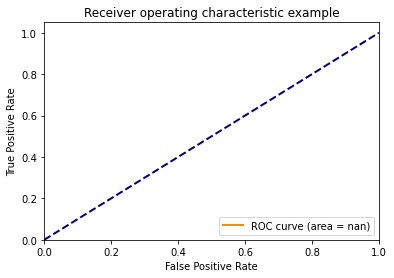

In [40]:
plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

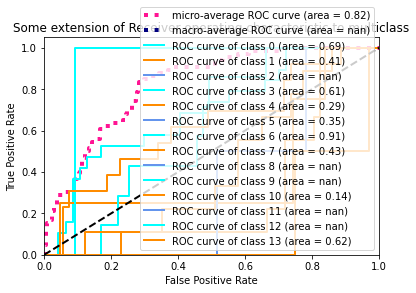

In [42]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()